## Setup the Env


In [34]:
import os
import sys

# import sagemaker
# from sagemaker import get_execution_role
# role = get_execution_role()
# role

# Add the parent directory to the sys.path
sys.path.insert(0, os.path.abspath(".."))

# Take a look at current dir
print(os.getcwd())

from utils.file_utilities import s3_download, s3_upload

/home/rcao/repos/capstone/src/ray


## Import Package


In [35]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import warnings
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
import joblib
import time
import logging
import torch.distributions as dist
from sklearn.preprocessing import StandardScaler


warnings.filterwarnings("ignore")
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

In [36]:
# pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113

In [37]:
torch.cuda.is_available()

True

In [38]:
import torch
import torch.nn as nn

# Check if CUDA is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("CUDA is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

# Example model
model = nn.Linear(10, 2)

# Move model to the device (GPU if available)
model.to(device)

# Example data
x = torch.randn(1, 10).to(device)
output = model(x)
print(output)

CUDA is available. Using GPU.
tensor([[0.4620, 0.7911]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [39]:
pd.set_option("display.max_rows", 20)
pd.set_option("display.max_columns", 500)

## Load Data


In [40]:
# reload_path = s3_download("CRSP/crsp_2018-2023_clean_3.parquet")
# reload_path

In [41]:
df = pd.read_parquet("../../data/crsp_2018-2023_clean_3.parquet")

In [42]:
df

,date,permno_id,ncusip_id,cusip_id,ticker,share_code,share_code_type,share_code_detail,exchange_code,company_name,primary_exchange,trading_status,security_status,naics,naics_sector,naics_sector_name,naics_secondary,ask_or_high_price,ask_price,bid_or_low_price,bid_price,open_price,close_price,return,volume,shares_outstanding,num_trades,factor_to_adjust_price,factor_to_adjust_shares,value_weighted_return,equal_weighted_return,return_on_SP_index,log_return,abs_log_return,market_cap,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,price_7,return_7,log_return_7,abs_log_return_7,price_14,return_14,log_return_14,abs_log_return_14,price_28,return_28,log_return_28,abs_log_return_28,volatility_7,volatility_14,volatility_28
9263,2018-01-02,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,N,A,R,511210.0,51,Information,1210.0,47.8011,46.63000,46.17000,46.62000,47.57000,46.63000,-0.013748,25380018,4139602,99,1.0,1.0,0.008505,0.011232,0.008303,-0.013843,0.013843,1.930296e+08,0.000000,0.000000,0.000000,0.000000,48.95,4.743043,0.309424,0.309424,51.12,4.231880,0.131071,0.131071,48.15,0.334682,0.011619,0.011619,0.136136,0.109282,0.276310
9264,2018-01-03,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,N,A,R,511210.0,51,Information,1210.0,48.0700,47.71000,47.44000,47.70000,47.53000,47.71000,0.023161,24165000,4139602,99,1.0,1.0,0.005856,0.005103,0.006399,0.022897,0.022897,1.975004e+08,0.006404,0.004872,0.005904,0.007983,49.51,2.793205,0.234088,0.234088,51.45,2.890159,0.107382,0.107382,48.49,0.157137,0.006475,0.006475,0.091648,0.081082,0.268724
9265,2018-01-04,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,N,A,R,511210.0,51,Information,1210.0,48.1900,48.18000,47.71500,48.17000,47.99000,48.18000,0.009851,19815057,4139602,99,1.0,1.0,0.004001,0.005272,0.004029,0.009803,0.009803,1.994460e+08,0.004048,0.000960,0.004021,0.000852,49.59,1.824771,0.183199,0.183199,51.60,2.436310,0.097613,0.097613,49.45,0.263850,0.009651,0.009651,0.089939,0.079524,0.273385
9266,2018-01-05,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,N,A,R,511210.0,51,Information,1210.0,48.6300,48.45000,48.28000,48.44000,48.42000,48.47000,0.006019,14496427,4139602,99,1.0,1.0,0.005804,0.003880,0.007034,0.006001,0.006001,2.006465e+08,0.009581,0.006722,0.006193,0.002919,50.27,2.716132,0.230474,0.230474,52.75,3.586591,0.120486,0.120486,50.64,0.483153,0.015437,0.015437,0.105015,0.107098,0.281463
9267,2018-01-08,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,N,A,R,511210.0,51,Information,1210.0,49.0700,48.99000,47.94000,48.98000,48.30000,48.98000,0.010522,15075007,4139602,99,1.0,1.0,0.001816,0.000584,0.001662,0.010467,0.010467,2.027577e+08,0.002142,0.005354,0.001829,0.005828,50.23,1.477412,0.161223,0.161223,51.94,1.875391,0.083731,0.083731,50.71,0.366701,0.012476,0.012476,0.105560,0.139328,0.280139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7656951,2023-12-22,93436,88160R10,88160R10,TSLA,11.0,1,1,3,TESLA INC,Q,A,R,336110.0,33,Manufacturing,6110.0,258.2200,252.53999,251.37000,252.53000,256.76001,252.53999,-0.007701,93148541,3178921,972876,1.0,1.0,0.002440,0.007676,0.001660,-0.007731,0.007731,8.028047e+08,0.000259,0.007069,0.002502,0.004469,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7656952,2023-12-26,93436,88160R10,88160R10,TSLA,11.0,1,1,3,TESLA INC,Q,A,R,336110.0,33,Manufacturing,6110.0,257.9700,256.70999,252.91000,256.66000,254.49001,256.60999,0.016116,86700724,3178921,954492,1.0,1.0,0.005218,0.009674,0.004232,0.015988,0.015988,8.157429e+08,0.007335,0.009616,0.005189,0.003873,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7656953,2023-12-27,93436,88160R10,88160R10,TSLA,11.0,1,1,3,TESLA INC,Q,

In [43]:
# Read the permno_ids from the text file
with open("./test_permno.txt", "r") as file:
    test_permno_ids = file.read().splitlines()

# Convert the permno_ids to integers (if necessary)
test_permno_ids = [permno_id for permno_id in test_permno_ids]

print(f"No. of Permno_ids: {len(test_permno_ids)}")
# # Filter the dataframe to include only the rows with permno_ids in the test_permno_ids list
df = df[df["permno_id"].isin(test_permno_ids)]

df

No. of Permno_ids: 472


,date,permno_id,ncusip_id,cusip_id,ticker,share_code,share_code_type,share_code_detail,exchange_code,company_name,primary_exchange,trading_status,security_status,naics,naics_sector,naics_sector_name,naics_secondary,ask_or_high_price,ask_price,bid_or_low_price,bid_price,open_price,close_price,return,volume,shares_outstanding,num_trades,factor_to_adjust_price,factor_to_adjust_shares,value_weighted_return,equal_weighted_return,return_on_SP_index,log_return,abs_log_return,market_cap,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,price_7,return_7,log_return_7,abs_log_return_7,price_14,return_14,log_return_14,abs_log_return_14,price_28,return_28,log_return_28,abs_log_return_28,volatility_7,volatility_14,volatility_28
9263,2018-01-02,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,N,A,R,511210.0,51,Information,1210.0,47.8011,46.63000,46.17000,46.62000,47.57000,46.63000,-0.013748,25380018,4139602,99,1.0,1.0,0.008505,0.011232,0.008303,-0.013843,0.013843,1.930296e+08,0.000000,0.000000,0.000000,0.000000,48.95,4.743043,0.309424,0.309424,51.12,4.231880,0.131071,0.131071,48.15,0.334682,0.011619,0.011619,0.136136,0.109282,0.276310
9264,2018-01-03,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,N,A,R,511210.0,51,Information,1210.0,48.0700,47.71000,47.44000,47.70000,47.53000,47.71000,0.023161,24165000,4139602,99,1.0,1.0,0.005856,0.005103,0.006399,0.022897,0.022897,1.975004e+08,0.006404,0.004872,0.005904,0.007983,49.51,2.793205,0.234088,0.234088,51.45,2.890159,0.107382,0.107382,48.49,0.157137,0.006475,0.006475,0.091648,0.081082,0.268724
9265,2018-01-04,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,N,A,R,511210.0,51,Information,1210.0,48.1900,48.18000,47.71500,48.17000,47.99000,48.18000,0.009851,19815057,4139602,99,1.0,1.0,0.004001,0.005272,0.004029,0.009803,0.009803,1.994460e+08,0.004048,0.000960,0.004021,0.000852,49.59,1.824771,0.183199,0.183199,51.60,2.436310,0.097613,0.097613,49.45,0.263850,0.009651,0.009651,0.089939,0.079524,0.273385
9266,2018-01-05,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,N,A,R,511210.0,51,Information,1210.0,48.6300,48.45000,48.28000,48.44000,48.42000,48.47000,0.006019,14496427,4139602,99,1.0,1.0,0.005804,0.003880,0.007034,0.006001,0.006001,2.006465e+08,0.009581,0.006722,0.006193,0.002919,50.27,2.716132,0.230474,0.230474,52.75,3.586591,0.120486,0.120486,50.64,0.483153,0.015437,0.015437,0.105015,0.107098,0.281463
9267,2018-01-08,10104,68389X10,68389X10,ORCL,11.0,1,1,1,ORACLE CORP,N,A,R,511210.0,51,Information,1210.0,49.0700,48.99000,47.94000,48.98000,48.30000,48.98000,0.010522,15075007,4139602,99,1.0,1.0,0.001816,0.000584,0.001662,0.010467,0.010467,2.027577e+08,0.002142,0.005354,0.001829,0.005828,50.23,1.477412,0.161223,0.161223,51.94,1.875391,0.083731,0.083731,50.71,0.366701,0.012476,0.012476,0.105560,0.139328,0.280139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7656951,2023-12-22,93436,88160R10,88160R10,TSLA,11.0,1,1,3,TESLA INC,Q,A,R,336110.0,33,Manufacturing,6110.0,258.2200,252.53999,251.37000,252.53000,256.76001,252.53999,-0.007701,93148541,3178921,972876,1.0,1.0,0.002440,0.007676,0.001660,-0.007731,0.007731,8.028047e+08,0.000259,0.007069,0.002502,0.004469,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7656952,2023-12-26,93436,88160R10,88160R10,TSLA,11.0,1,1,3,TESLA INC,Q,A,R,336110.0,33,Manufacturing,6110.0,257.9700,256.70999,252.91000,256.66000,254.49001,256.60999,0.016116,86700724,3178921,954492,1.0,1.0,0.005218,0.009674,0.004232,0.015988,0.015988,8.157429e+08,0.007335,0.009616,0.005189,0.003873,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7656953,2023-12-27,93436,88160R10,88160R10,TSLA,11.0,1,1,3,TESLA INC,Q,

In [44]:
df.dtypes

date                 datetime64[ns]
permno_id                    object
ncusip_id                    object
cusip_id                     object
ticker                       object
                          ...      
log_return_28               float64
abs_log_return_28           float64
volatility_7                float64
volatility_14               float64
volatility_28               float64
Length: 54, dtype: object

## Feature Engineering


### Feature Selection


In [45]:
data = df[
    [
        "date",
        "permno_id",
        # "naics",
        "log_return",
        "abs_log_return",
        "sector_weighted_avg_log_return",
        "sector_simple_avg_log_return",
        "weighted_avg_log_return",
        "simple_avg_log_return",
        "log_return_7",
        "abs_log_return_7",
        "log_return_14",
        "abs_log_return_14",
        "log_return_28",
        "abs_log_return_28",
        "volatility_7",
        "volatility_14",
        "volatility_28",
    ]
].copy()
data

,date,permno_id,log_return,abs_log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,log_return_7,abs_log_return_7,log_return_14,abs_log_return_14,log_return_28,abs_log_return_28,volatility_7,volatility_14,volatility_28
9263,2018-01-02,10104,-0.013843,0.013843,0.000000,0.000000,0.000000,0.000000,0.309424,0.309424,0.131071,0.131071,0.011619,0.011619,0.136136,0.109282,0.276310
9264,2018-01-03,10104,0.022897,0.022897,0.006404,0.004872,0.005904,0.007983,0.234088,0.234088,0.107382,0.107382,0.006475,0.006475,0.091648,0.081082,0.268724
9265,2018-01-04,10104,0.009803,0.009803,0.004048,0.000960,0.004021,0.000852,0.183199,0.183199,0.097613,0.097613,0.009651,0.009651,0.089939,0.079524,0.273385
9266,2018-01-05,10104,0.006001,0.006001,0.009581,0.006722,0.006193,0.002919,0.230474,0.230474,0.120486,0.120486,0.015437,0.015437,0.105015,0.107098,0.281463
9267,2018-01-08,10104,0.010467,0.010467,0.002142,0.005354,0.001829,0.005828,0.161223,0.161223,0.083731,0.083731,0.012476,0.012476,0.105560,0.139328,0.280139
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7656951,2023-12-22,93436,-0.007731,0.007731,0.000259,0.007069,0.002502,0.004469,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7656952,2023-12-26,93436,0.015988,0.015988,0.007335,0.009616,0.005189,0.003873,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7656953,2023-12-27,93436,0.018647,0.018647,0.002344,0.001393,0.001653,0.001163,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7656954,2023-12-28,93436,-0.032104,0.032104,-0.001451,-0.000214,-0.000266,0.002184,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### Standardize features and labels


In [46]:
columns = [
    "log_return",
    "sector_weighted_avg_log_return",
    "sector_simple_avg_log_return",
    "weighted_avg_log_return",
    "simple_avg_log_return",
    "abs_log_return",
    "log_return_7",
    "abs_log_return_7",
    "log_return_14",
    "abs_log_return_14",
    "log_return_28",
    "abs_log_return_28",
    "volatility_7",
    "volatility_14",
    "volatility_28",
]
scaler = StandardScaler()

data[columns] = scaler.fit_transform(data[columns])
data

,date,permno_id,log_return,abs_log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,log_return_7,abs_log_return_7,log_return_14,abs_log_return_14,log_return_28,abs_log_return_28,volatility_7,volatility_14,volatility_28
9263,2018-01-02,10104,-0.619266,-0.060815,-0.018419,-0.009250,-0.025157,-0.017922,0.538658,0.225722,1.137374,0.758914,0.220082,-0.550952,-0.717463,-0.950839,-0.166242
9264,2018-01-03,10104,0.981667,0.457884,0.330585,0.302691,0.420254,0.618812,0.376500,0.044527,0.911634,0.445860,0.079068,-0.749317,-0.920619,-1.089576,-0.205730
9265,2018-01-04,10104,0.411102,-0.292311,0.202188,0.052217,0.278196,0.050035,0.266963,-0.077869,0.818538,0.316755,0.166129,-0.626848,-0.928421,-1.097240,-0.181467
9266,2018-01-05,10104,0.245439,-0.510129,0.503724,0.421142,0.442057,0.214901,0.368721,0.035835,1.036502,0.619025,0.324745,-0.403720,-0.859578,-0.961583,-0.139419
9267,2018-01-08,10104,0.440045,-0.254256,0.098315,0.333553,0.112827,0.446927,0.219660,-0.130725,0.686248,0.133298,0.243571,-0.517909,-0.857091,-0.803019,-0.146311
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7656951,2023-12-22,93436,-0.352914,-0.411021,-0.004304,0.443359,0.163599,0.338531,-0.127367,-0.518493,-0.111651,-0.973221,-0.098430,-0.999006,-1.339135,-1.488479,-1.604434
7656952,2023-12-26,93436,0.680597,0.062028,0.381322,0.606437,0.366313,0.290993,-0.127367,-0.518493,-0.111651,-0.973221,-0.098430,-0.999006,-1.339135,-1.488479,-1.604434
7656953,2023-12-27,93436,0.796485,0.214401,0.109324,0.079940,0.099549,0.074840,-0.127367,-0.518493,-0.111651,-0.973221,-0.098430,-0.999006,-1.339135,-1.488479,-1.604434
7656954,2023-12-28,93436,-1.414955,0.985378,-0.097496,-0.022951,-0.045225,0.156277,-0.127367,-0.518493,-0.111651,-0.973221,-0.098430,-0.999006,-1.339135,-1.488479,-1.604434


### Select number of stocks


In [47]:
data["permno_id"].nunique()

472

In [48]:
# Function to filter the first n stocks
def filter_first_n_stocks(data, n):
    first_n_permno_ids = data["permno_id"].unique()[:n]
    return data[data["permno_id"].isin(first_n_permno_ids)]

In [49]:
# Filter the first n stocks
n_stocks = 96  # Adjust n as needed
data = filter_first_n_stocks(data, n_stocks)
data

,date,permno_id,log_return,abs_log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,log_return_7,abs_log_return_7,log_return_14,abs_log_return_14,log_return_28,abs_log_return_28,volatility_7,volatility_14,volatility_28
9263,2018-01-02,10104,-0.619266,-0.060815,-0.018419,-0.009250,-0.025157,-0.017922,0.538658,0.225722,1.137374,0.758914,0.220082,-0.550952,-0.717463,-0.950839,-0.166242
9264,2018-01-03,10104,0.981667,0.457884,0.330585,0.302691,0.420254,0.618812,0.376500,0.044527,0.911634,0.445860,0.079068,-0.749317,-0.920619,-1.089576,-0.205730
9265,2018-01-04,10104,0.411102,-0.292311,0.202188,0.052217,0.278196,0.050035,0.266963,-0.077869,0.818538,0.316755,0.166129,-0.626848,-0.928421,-1.097240,-0.181467
9266,2018-01-05,10104,0.245439,-0.510129,0.503724,0.421142,0.442057,0.214901,0.368721,0.035835,1.036502,0.619025,0.324745,-0.403720,-0.859578,-0.961583,-0.139419
9267,2018-01-08,10104,0.440045,-0.254256,0.098315,0.333553,0.112827,0.446927,0.219660,-0.130725,0.686248,0.133298,0.243571,-0.517909,-0.857091,-0.803019,-0.146311
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148266,2023-12-22,11618,0.150999,-0.634301,0.270528,0.345846,0.163599,0.338531,-0.127367,-0.518493,-0.111651,-0.973221,-0.098430,-0.999006,-1.339135,-1.488479,-1.604434
148267,2023-12-26,11618,0.057268,-0.757541,0.291455,0.525314,0.366313,0.290993,-0.127367,-0.518493,-0.111651,-0.973221,-0.098430,-0.999006,-1.339135,-1.488479,-1.604434
148268,2023-12-27,11618,-0.089359,-0.757551,-0.015149,0.024493,0.099549,0.074840,-0.127367,-0.518493,-0.111651,-0.973221,-0.098430,-0.999006,-1.339135,-1.488479,-1.604434
148269,2023-12-28,11618,-0.350763,-0.413850,-0.142892,-0.165156,-0.045225,0.156277,-0.127367,-0.518493,-0.111651,-0.973221,-0.098430,-0.999006,-1.339135,-1.488479,-1.604434


### Remove Stock with less than 1500 dates' data


In [50]:
data.groupby("permno_id").nunique()

,date,log_return,abs_log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,log_return_7,abs_log_return_7,log_return_14,abs_log_return_14,log_return_28,abs_log_return_28,volatility_7,volatility_14,volatility_28
permno_id,,,,,,,,,,,,,,,,
10104,1509,1494,1494,1483,1490,1482,1484,1503,1503,1496,1496,1482,1482,1503,1496,1482
10107,1509,1491,1491,1482,1489,1482,1484,1503,1503,1496,1496,1482,1482,1503,1496,1482
10138,1509,1490,1490,1480,1480,1482,1484,1503,1503,1496,1496,1482,1482,1503,1496,1482
10145,1509,1477,1477,1477,1480,1482,1484,1503,1503,1496,1496,1482,1482,1503,1496,1482
10516,1509,1482,1482,1480,1467,1482,1484,1503,1503,1496,1496,1482,1482,1503,1496,1482
11308,1509,1467,1467,1480,1467,1482,1484,1502,1502,1496,1496,1481,1481,1502,1496,1481
11403,1509,1494,1494,1475,1481,1482,1484,1503,1503,1496,1496,1482,1482,1503,1496,1482
11404,1509,1472,1472,1471,1483,1482,1484,1503,1503,1496,1496,1482,1482,1503,1496,1482
11600,1509,1489,1489,1488,1477,1482,1484,1503,1503,1496,1496,1482,1482,1503,1496,1482


In [51]:
grouped_data = data.groupby("permno_id")["date"].nunique().reset_index()
grouped_data.columns = ["permno_id", "date_count"]

filtered_permno_ids = grouped_data[grouped_data["date_count"] > 1500]["permno_id"]
print(filtered_permno_ids)
data = data[data["permno_id"].isin(filtered_permno_ids)]
data

0    10104
1    10107
2    10138
3    10145
4    10516
5    11308
6    11403
7    11404
8    11600
9    11618
Name: permno_id, dtype: object


,date,permno_id,log_return,abs_log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,log_return_7,abs_log_return_7,log_return_14,abs_log_return_14,log_return_28,abs_log_return_28,volatility_7,volatility_14,volatility_28
9263,2018-01-02,10104,-0.619266,-0.060815,-0.018419,-0.009250,-0.025157,-0.017922,0.538658,0.225722,1.137374,0.758914,0.220082,-0.550952,-0.717463,-0.950839,-0.166242
9264,2018-01-03,10104,0.981667,0.457884,0.330585,0.302691,0.420254,0.618812,0.376500,0.044527,0.911634,0.445860,0.079068,-0.749317,-0.920619,-1.089576,-0.205730
9265,2018-01-04,10104,0.411102,-0.292311,0.202188,0.052217,0.278196,0.050035,0.266963,-0.077869,0.818538,0.316755,0.166129,-0.626848,-0.928421,-1.097240,-0.181467
9266,2018-01-05,10104,0.245439,-0.510129,0.503724,0.421142,0.442057,0.214901,0.368721,0.035835,1.036502,0.619025,0.324745,-0.403720,-0.859578,-0.961583,-0.139419
9267,2018-01-08,10104,0.440045,-0.254256,0.098315,0.333553,0.112827,0.446927,0.219660,-0.130725,0.686248,0.133298,0.243571,-0.517909,-0.857091,-0.803019,-0.146311
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148266,2023-12-22,11618,0.150999,-0.634301,0.270528,0.345846,0.163599,0.338531,-0.127367,-0.518493,-0.111651,-0.973221,-0.098430,-0.999006,-1.339135,-1.488479,-1.604434
148267,2023-12-26,11618,0.057268,-0.757541,0.291455,0.525314,0.366313,0.290993,-0.127367,-0.518493,-0.111651,-0.973221,-0.098430,-0.999006,-1.339135,-1.488479,-1.604434
148268,2023-12-27,11618,-0.089359,-0.757551,-0.015149,0.024493,0.099549,0.074840,-0.127367,-0.518493,-0.111651,-0.973221,-0.098430,-0.999006,-1.339135,-1.488479,-1.604434
148269,2023-12-28,11618,-0.350763,-0.413850,-0.142892,-0.165156,-0.045225,0.156277,-0.127367,-0.518493,-0.111651,-0.973221,-0.098430,-0.999006,-1.339135,-1.488479,-1.604434


In [52]:
data.groupby("permno_id").nunique()

,date,log_return,abs_log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,log_return_7,abs_log_return_7,log_return_14,abs_log_return_14,log_return_28,abs_log_return_28,volatility_7,volatility_14,volatility_28
permno_id,,,,,,,,,,,,,,,,
10104,1509,1494,1494,1483,1490,1482,1484,1503,1503,1496,1496,1482,1482,1503,1496,1482
10107,1509,1491,1491,1482,1489,1482,1484,1503,1503,1496,1496,1482,1482,1503,1496,1482
10138,1509,1490,1490,1480,1480,1482,1484,1503,1503,1496,1496,1482,1482,1503,1496,1482
10145,1509,1477,1477,1477,1480,1482,1484,1503,1503,1496,1496,1482,1482,1503,1496,1482
10516,1509,1482,1482,1480,1467,1482,1484,1503,1503,1496,1496,1482,1482,1503,1496,1482
11308,1509,1467,1467,1480,1467,1482,1484,1502,1502,1496,1496,1481,1481,1502,1496,1481
11403,1509,1494,1494,1475,1481,1482,1484,1503,1503,1496,1496,1482,1482,1503,1496,1482
11404,1509,1472,1472,1471,1483,1482,1484,1503,1503,1496,1496,1482,1482,1503,1496,1482
11600,1509,1489,1489,1488,1477,1482,1484,1503,1503,1496,1496,1482,1482,1503,1496,1482


In [53]:
def create_rolling_features_with_positional_encoding(data, input_columns, target_columns, window_size):
    # Sort data by permno_id and date
    data = data.sort_values(by=["permno_id", "date"])

    # Create rolling window features for each group of permno_id
    for col in input_columns:
        for i in range(1, window_size + 1):
            data[f"{col}_past_{i}"] = data.groupby("permno_id")[col].shift(i)

    # # Add positional encoding
    # data["positional_encoding"] = data.groupby("permno_id").cumcount() + 1

    # Drop rows with NaN values created by the shift operation
    data = data.dropna()

    return data

In [54]:
# Input parameters
input_columns = [
    "log_return",
    # "sector_weighted_avg_log_return",
    # "sector_simple_avg_log_return",
    "weighted_avg_log_return",
    "simple_avg_log_return",
]
target_columns = [
    "log_return",
    "abs_log_return",
    "log_return_7",
    "abs_log_return_7",
    "log_return_14",
    "abs_log_return_14",
    "log_return_28",
    "abs_log_return_28",
    "volatility_7",
    "volatility_14",
    "volatility_28",
]

window_size = 128

In [55]:
data[-30:]

,date,permno_id,log_return,abs_log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,log_return_7,abs_log_return_7,log_return_14,abs_log_return_14,log_return_28,abs_log_return_28,volatility_7,volatility_14,volatility_28
148241,2023-11-16,11618,0.380843,-0.332096,-0.106651,-0.276243,-0.125797,0.310216,-0.262493,-0.367504,0.312566,-0.384921,0.551244,-0.085102,-0.816064,-0.792734,-0.993134
148242,2023-11-17,11618,0.048567,-0.768981,0.338923,0.453476,0.212939,-0.070245,-0.322115,-0.300882,0.279265,-0.431103,0.528131,-0.117615,-0.823777,-0.788970,-0.990641
148243,2023-11-20,11618,0.105702,-0.693859,0.209164,0.193717,0.515236,0.522939,-0.294499,-0.331740,0.460483,-0.179792,-0.098430,-0.999006,-0.794101,-0.724879,-1.604434
148244,2023-11-21,11618,-0.173681,-0.646682,-0.050519,-0.149661,-0.263555,-0.114832,-0.105385,-0.493931,0.616867,0.037080,-0.098430,-0.999006,-0.639482,-0.734551,-1.604434
148245,2023-11-22,11618,0.105832,-0.693688,0.226494,0.249997,0.288004,0.311891,-0.109119,-0.498103,0.612974,0.031682,-0.098430,-0.999006,-0.640475,-0.734288,-1.604434
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148266,2023-12-22,11618,0.150999,-0.634301,0.270528,0.345846,0.163599,0.338531,-0.127367,-0.518493,-0.111651,-0.973221,-0.098430,-0.999006,-1.339135,-1.488479,-1.604434
148267,2023-12-26,11618,0.057268,-0.757541,0.291455,0.525314,0.366313,0.290993,-0.127367,-0.518493,-0.111651,-0.973221,-0.098430,-0.999006,-1.339135,-1.488479,-1.604434
148268,2023-12-27,11618,-0.089359,-0.757551,-0.015149,0.024493,0.099549,0.074840,-0.127367,-0.518493,-0.111651,-0.973221,-0.098430,-0.999006,-1.339135,-1.488479,-1.604434
148269,2023-12-28,11618,-0.350763,-0.413850,-0.142892,-0.165156,-0.045225,0.156277,-0.127367,-0.518493,-0.111651,-0.973221,-0.098430,-0.999006,-1.339135,-1.488479,-1.604434


In [56]:
# (None, 128, n + 2 + n )

### Remove last 28 rows


In [57]:
# Define a function to remove the last 28 rows for each permno_id
def remove_last_n_rows(df, n):
    # Group by 'permno_id'
    groups = df.groupby("permno_id")
    # Remove last n rows for each group
    df_cleaned = groups.apply(lambda x: x.iloc[:-n] if len(x) > n else x)
    # Remove the extra groupby level
    df_cleaned.reset_index(drop=True, inplace=True)
    return df_cleaned

In [58]:
# Remove the last 28 rows for each permno_id
cleaned_data = remove_last_n_rows(data, 28)
cleaned_data[-30:]

,date,permno_id,log_return,abs_log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,log_return_7,abs_log_return_7,log_return_14,abs_log_return_14,log_return_28,abs_log_return_28,volatility_7,volatility_14,volatility_28
14780,2023-10-09,11618,0.254880,-0.497715,0.456039,0.495478,0.393623,-0.047194,0.367822,0.034831,0.213551,-0.522234,0.594686,-0.023990,0.882549,0.213417,-0.189349
14781,2023-10-10,11618,-0.497098,-0.221445,0.194667,0.052729,0.462803,0.677197,0.459331,0.137083,0.492942,-0.134778,0.708042,0.135468,0.845887,0.196498,-0.206858
14782,2023-10-11,11618,0.108613,-0.690032,0.049812,-0.027305,0.260769,0.062477,0.208124,-0.143616,0.480263,-0.152361,0.707436,0.134616,0.932996,0.196771,-0.206854
14783,2023-10-12,11618,3.141967,3.298303,-0.421376,-0.756320,-0.687540,-0.822314,-0.600888,0.010618,-0.304255,-0.706120,0.025649,-0.824462,-0.719895,-0.791915,-0.767775
14784,2023-10-13,11618,-0.088486,-0.758698,-0.238046,-0.464163,-0.436393,-0.304026,-0.555893,-0.039659,-0.089835,-0.942967,0.065148,-0.768899,-0.667941,-0.705969,-0.767794
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14805,2023-11-13,11618,-0.285561,-0.499580,-0.051935,-0.004896,-0.055334,-0.073835,0.110906,-0.252248,0.162447,-0.593105,0.774368,0.228770,-0.513277,-0.689317,-0.880855
14806,2023-11-14,11618,0.966418,0.437833,1.127888,1.729732,1.671162,1.431898,-0.134602,-0.510410,-0.085524,-0.936988,0.585312,-0.037177,-0.799879,-0.840777,-0.949793
14807,2023-11-15,11618,-0.656483,-0.011881,-0.164092,-0.151390,0.117202,0.532909,0.031885,-0.340545,0.382084,-0.288515,0.703095,0.128510,-1.060610,-0.779038,-1.008530
14808,2023-11-16,11618,0.380843,-0.332096,-0.106651,-0.276243,-0.125797,0.310216,-0.262493,-0.367504,0.312566,-0.384921,0.551244,-0.085102,-0.816064,-0.792734,-0.993134


In [59]:
data.groupby("permno_id").nunique()

,date,log_return,abs_log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,log_return_7,abs_log_return_7,log_return_14,abs_log_return_14,log_return_28,abs_log_return_28,volatility_7,volatility_14,volatility_28
permno_id,,,,,,,,,,,,,,,,
10104,1509,1494,1494,1483,1490,1482,1484,1503,1503,1496,1496,1482,1482,1503,1496,1482
10107,1509,1491,1491,1482,1489,1482,1484,1503,1503,1496,1496,1482,1482,1503,1496,1482
10138,1509,1490,1490,1480,1480,1482,1484,1503,1503,1496,1496,1482,1482,1503,1496,1482
10145,1509,1477,1477,1477,1480,1482,1484,1503,1503,1496,1496,1482,1482,1503,1496,1482
10516,1509,1482,1482,1480,1467,1482,1484,1503,1503,1496,1496,1482,1482,1503,1496,1482
11308,1509,1467,1467,1480,1467,1482,1484,1502,1502,1496,1496,1481,1481,1502,1496,1481
11403,1509,1494,1494,1475,1481,1482,1484,1503,1503,1496,1496,1482,1482,1503,1496,1482
11404,1509,1472,1472,1471,1483,1482,1484,1503,1503,1496,1496,1482,1482,1503,1496,1482
11600,1509,1489,1489,1488,1477,1482,1484,1503,1503,1496,1496,1482,1482,1503,1496,1482


In [60]:
# set the index to be date and permno_id, with the name

# cleaned_data.set_index(["date", "permno_id"], inplace=True)
# cleaned_data.index.set_names(["date", "permno_id"], inplace=True)
# cleaned_data.index

## Model

1. Need to have 1 modified transformer encoder layer without residual connections + (n-1) standard layers
2. Need to connect the output of the first transformer block to the embedding layer of the fi- nal encoder block


### Cases: 4 dimensions input


In [61]:
cleaned_data = cleaned_data.sort_values(by=["date", "permno_id"])
cleaned_data

,date,permno_id,log_return,abs_log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,log_return_7,abs_log_return_7,log_return_14,abs_log_return_14,log_return_28,abs_log_return_28,volatility_7,volatility_14,volatility_28
0,2018-01-02,10104,-0.619266,-0.060815,-0.018419,-0.009250,-0.025157,-0.017922,0.538658,0.225722,1.137374,0.758914,0.220082,-0.550952,-0.717463,-0.950839,-0.166242
1481,2018-01-02,10107,0.192304,-0.579992,-0.018419,-0.009250,-0.025157,-0.017922,0.161408,-0.195816,0.744753,0.214431,0.223537,-0.546091,-0.925383,-0.744637,0.070212
2962,2018-01-02,10138,-0.791163,0.165199,-0.018419,-0.009250,-0.025157,-0.017922,1.182313,0.944942,1.707118,1.549029,0.058776,-0.777863,-0.823496,-0.744941,0.007712
4443,2018-01-02,10145,0.083274,-0.723348,-0.018419,-0.009250,-0.025157,-0.017922,0.193532,-0.159922,0.359581,-0.319721,-0.343780,-0.653870,-0.773966,-0.966528,-0.415285
5924,2018-01-02,10516,-0.005201,-0.839677,-0.018419,-0.009250,-0.025157,-0.017922,0.005603,-0.369913,0.665321,0.104275,0.158365,-0.637769,-0.555524,-0.382779,-0.337080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8885,2023-11-17,11308,0.067751,-0.743758,-0.009482,0.377603,0.212939,-0.070245,0.066873,-0.301450,0.277675,-0.433308,0.225851,-0.542837,-0.942178,-1.107761,-1.012204
10366,2023-11-17,11403,0.192347,-0.579935,-0.278483,0.266772,0.212939,-0.070245,0.174784,-0.180870,-0.490811,-0.447406,0.035549,-0.810537,-0.867416,-0.655386,-0.560691
11847,2023-11-17,11404,0.093794,-0.709516,0.130850,0.114259,0.212939,-0.070245,-0.293954,-0.332349,-0.086155,-0.937863,-0.136110,-0.946002,-0.992462,-0.893637,-0.774258
13328,2023-11-17,11600,0.116259,-0.679978,0.111558,0.243594,0.212939,-0.070245,0.558224,0.247585,0.801447,0.293054,1.582747,1.365927,-0.386233,-0.379688,-0.297252


In [62]:
cleaned_data.groupby("permno_id")["date"].count()

permno_id
10104    1481
10107    1481
10138    1481
10145    1481
10516    1481
11308    1481
11403    1481
11404    1481
11600    1481
11618    1481
Name: date, dtype: int64

In [63]:
# cleaned_data.index.get_level_values("date").unique()

# get the row index starting from the 129th date

In [64]:
cleaned_data.head()

,date,permno_id,log_return,abs_log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,weighted_avg_log_return,simple_avg_log_return,log_return_7,abs_log_return_7,log_return_14,abs_log_return_14,log_return_28,abs_log_return_28,volatility_7,volatility_14,volatility_28
0,2018-01-02,10104,-0.619266,-0.060815,-0.018419,-0.00925,-0.025157,-0.017922,0.538658,0.225722,1.137374,0.758914,0.220082,-0.550952,-0.717463,-0.950839,-0.166242
1481,2018-01-02,10107,0.192304,-0.579992,-0.018419,-0.00925,-0.025157,-0.017922,0.161408,-0.195816,0.744753,0.214431,0.223537,-0.546091,-0.925383,-0.744637,0.070212
2962,2018-01-02,10138,-0.791163,0.165199,-0.018419,-0.00925,-0.025157,-0.017922,1.182313,0.944942,1.707118,1.549029,0.058776,-0.777863,-0.823496,-0.744941,0.007712
4443,2018-01-02,10145,0.083274,-0.723348,-0.018419,-0.00925,-0.025157,-0.017922,0.193532,-0.159922,0.359581,-0.319721,-0.343780,-0.653870,-0.773966,-0.966528,-0.415285
5924,2018-01-02,10516,-0.005201,-0.839677,-0.018419,-0.00925,-0.025157,-0.017922,0.005603,-0.369913,0.665321,0.104275,0.158365,-0.637769,-0.555524,-0.382779,-0.337080


#### Generate the input data to the model


In [65]:
pivot_data = cleaned_data[["date", "permno_id", "log_return"]].pivot(index="date", columns="permno_id")
pivot_data.columns = pivot_data.columns.droplevel(0)
pivot_data

permno_id,10104,10107,10138,10145,10516,11308,11403,11404,11600,11618
date,,,,,,,,,,
2018-01-02,-0.619266,0.192304,-0.791163,0.083274,-0.005201,-0.340182,0.222953,-0.724501,0.842566,-0.135738
2018-01-03,0.981667,0.186276,0.575965,-0.377556,-0.354320,-0.111844,0.886422,-0.429873,-0.165591,-0.000060
2018-01-04,0.411102,0.365771,0.324588,0.568829,0.711762,0.593414,0.638766,-0.529581,-0.022542,0.159289
2018-01-05,0.245439,0.520865,0.771244,0.287476,-0.307883,-0.025506,0.391982,-0.058686,0.591953,0.071360
2018-01-08,0.440045,0.028374,1.047714,-0.251945,-0.113765,-0.082289,0.895554,0.592726,0.278431,0.441986
...,...,...,...,...,...,...,...,...,...,...
2023-11-13,0.398198,-0.369912,-0.147974,-0.062742,0.307290,0.144965,0.378641,-0.496613,-0.759060,-0.285561
2023-11-14,0.722045,0.408513,2.138246,0.846795,0.735110,0.113870,1.393880,1.410034,1.563058,0.966418
2023-11-15,-0.788501,0.001595,0.581682,-0.174381,0.207566,0.067794,-1.121626,0.008041,0.552402,-0.656483


In [66]:
pivot_data = cleaned_data[["date", "permno_id", "log_return"]].pivot(index="date", columns="permno_id")
pivot_data.columns = pivot_data.columns.droplevel(0)
pivot_data

permno_id,10104,10107,10138,10145,10516,11308,11403,11404,11600,11618
date,,,,,,,,,,
2018-01-02,-0.619266,0.192304,-0.791163,0.083274,-0.005201,-0.340182,0.222953,-0.724501,0.842566,-0.135738
2018-01-03,0.981667,0.186276,0.575965,-0.377556,-0.354320,-0.111844,0.886422,-0.429873,-0.165591,-0.000060
2018-01-04,0.411102,0.365771,0.324588,0.568829,0.711762,0.593414,0.638766,-0.529581,-0.022542,0.159289
2018-01-05,0.245439,0.520865,0.771244,0.287476,-0.307883,-0.025506,0.391982,-0.058686,0.591953,0.071360
2018-01-08,0.440045,0.028374,1.047714,-0.251945,-0.113765,-0.082289,0.895554,0.592726,0.278431,0.441986
...,...,...,...,...,...,...,...,...,...,...
2023-11-13,0.398198,-0.369912,-0.147974,-0.062742,0.307290,0.144965,0.378641,-0.496613,-0.759060,-0.285561
2023-11-14,0.722045,0.408513,2.138246,0.846795,0.735110,0.113870,1.393880,1.410034,1.563058,0.966418
2023-11-15,-0.788501,0.001595,0.581682,-0.174381,0.207566,0.067794,-1.121626,0.008041,0.552402,-0.656483


In [67]:
pivot_data.index

DatetimeIndex(['2018-01-02', '2018-01-03', '2018-01-04', '2018-01-05',
               '2018-01-08', '2018-01-09', '2018-01-10', '2018-01-11',
               '2018-01-12', '2018-01-16',
               ...
               '2023-11-06', '2023-11-07', '2023-11-08', '2023-11-09',
               '2023-11-10', '2023-11-13', '2023-11-14', '2023-11-15',
               '2023-11-16', '2023-11-17'],
              dtype='datetime64[ns]', name='date', length=1481, freq=None)

In [68]:
pivot_data.columns

Index(['10104', '10107', '10138', '10145', '10516', '11308', '11403', '11404',
       '11600', '11618'],
      dtype='object', name='permno_id')

In [69]:
market_columns = ["weighted_avg_log_return", "simple_avg_log_return"]
market_data_df = cleaned_data[["date"] + market_columns].drop_duplicates(subset=["date"]).set_index("date")
input_data = pivot_data.join(market_data_df, how="left")
input_data

,10104,10107,10138,10145,10516,11308,11403,11404,11600,11618,weighted_avg_log_return,simple_avg_log_return
date,,,,,,,,,,,,
2018-01-02,-0.619266,0.192304,-0.791163,0.083274,-0.005201,-0.340182,0.222953,-0.724501,0.842566,-0.135738,-0.025157,-0.017922
2018-01-03,0.981667,0.186276,0.575965,-0.377556,-0.354320,-0.111844,0.886422,-0.429873,-0.165591,-0.000060,0.420254,0.618812
2018-01-04,0.411102,0.365771,0.324588,0.568829,0.711762,0.593414,0.638766,-0.529581,-0.022542,0.159289,0.278196,0.050035
2018-01-05,0.245439,0.520865,0.771244,0.287476,-0.307883,-0.025506,0.391982,-0.058686,0.591953,0.071360,0.442057,0.214901
2018-01-08,0.440045,0.028374,1.047714,-0.251945,-0.113765,-0.082289,0.895554,0.592726,0.278431,0.441986,0.112827,0.446927
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-13,0.398198,-0.369912,-0.147974,-0.062742,0.307290,0.144965,0.378641,-0.496613,-0.759060,-0.285561,-0.055334,-0.073835
2023-11-14,0.722045,0.408513,2.138246,0.846795,0.735110,0.113870,1.393880,1.410034,1.563058,0.966418,1.671162,1.431898
2023-11-15,-0.788501,0.001595,0.581682,-0.174381,0.207566,0.067794,-1.121626,0.008041,0.552402,-0.656483,0.117202,0.532909


#### Generate the lable data to the model


In [70]:
raw_output_data = cleaned_data.drop(market_columns, axis=1)
# drop the first 128 dates for each permno_id
raw_output_data = raw_output_data.groupby("permno_id").nth[128:]

raw_output_data.date.unique()

<DatetimeArray>
['2018-07-06 00:00:00', '2018-07-09 00:00:00', '2018-07-10 00:00:00',
 '2018-07-11 00:00:00', '2018-07-12 00:00:00', '2018-07-13 00:00:00',
 '2018-07-16 00:00:00', '2018-07-17 00:00:00', '2018-07-18 00:00:00',
 '2018-07-19 00:00:00',
 ...
 '2023-11-06 00:00:00', '2023-11-07 00:00:00', '2023-11-08 00:00:00',
 '2023-11-09 00:00:00', '2023-11-10 00:00:00', '2023-11-13 00:00:00',
 '2023-11-14 00:00:00', '2023-11-15 00:00:00', '2023-11-16 00:00:00',
 '2023-11-17 00:00:00']
Length: 1353, dtype: datetime64[ns]

In [71]:
raw_output_data = raw_output_data.sort_values(by=["date", "permno_id"]).reset_index(drop=True).set_index("date")
raw_output_data

,permno_id,log_return,abs_log_return,sector_weighted_avg_log_return,sector_simple_avg_log_return,log_return_7,abs_log_return_7,log_return_14,abs_log_return_14,log_return_28,abs_log_return_28,volatility_7,volatility_14,volatility_28
date,,,,,,,,,,,,,,
2018-07-06,10104,0.546466,-0.114330,0.708745,0.863506,0.727810,0.437080,0.711450,0.168247,0.284282,-0.460641,-0.968789,-0.976923,-0.953075
2018-07-06,10107,0.591222,-0.055484,0.708745,0.863506,0.450823,0.127575,0.924998,0.464392,0.490826,-0.170093,-0.697054,-0.528842,-0.626643
2018-07-06,10138,-0.012258,-0.848956,0.277340,0.037426,0.386545,0.055751,0.540244,-0.069180,-0.099192,-0.997935,-0.668842,-0.383568,-0.512304
2018-07-06,10145,0.223820,-0.538554,0.170416,0.303844,0.091521,-0.273908,1.029506,0.609324,0.345020,-0.375199,-0.202193,-0.306221,-0.505072
2018-07-06,10516,0.330467,-0.398332,0.161587,0.242634,0.122969,-0.238768,0.151457,-0.608345,0.467306,-0.203178,-0.655986,-0.892484,-0.847863
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-17,11308,0.067751,-0.743758,-0.009482,0.377603,0.066873,-0.301450,0.277675,-0.433308,0.225851,-0.542837,-0.942178,-1.107761,-1.012204
2023-11-17,11403,0.192347,-0.579935,-0.278483,0.266772,0.174784,-0.180870,-0.490811,-0.447406,0.035549,-0.810537,-0.867416,-0.655386,-0.560691
2023-11-17,11404,0.093794,-0.709516,0.130850,0.114259,-0.293954,-0.332349,-0.086155,-0.937863,-0.136110,-0.946002,-0.992462,-0.893637,-0.774258


In [72]:
raw_output_data[
    [
        "log_return",
        "abs_log_return",
        "log_return_7",
        "abs_log_return_7",
        "log_return_14",
        "abs_log_return_14",
        "log_return_28",
        "abs_log_return_28",
        "volatility_7",
        "volatility_14",
        "volatility_28",
    ]
].loc[pd.Timestamp("2018-07-06")].iloc[1].values.T.squeeze()

array([ 0.59122236, -0.05548374,  0.45082267,  0.12757518,  0.92499761,
        0.46439249,  0.49082575, -0.17009258, -0.69705402, -0.52884197,
       -0.6266428 ])

In [ ]:
for compustat_feature in [
    "assets",
    "liabs",
    "retained_earning",
    "net_sales",
    "net_income",
    "common_shares_outstanding",
]:

    compu_data = cleaned_data[["date", "permno_id", compustat_feature]].pivot(index="date", columns="permno_id")
    compu_data.columns = compu_data.columns.droplevel(0)
    compu_data.columns = [f"{compustat_feature}_{col}" for col in compu_data.columns]
    pivot_data = pd.concat([pivot_data, compu_data], axis=1)

#### Create Dataset


In [73]:
class FinancialDataset(Dataset):
    def __init__(self, input_data, raw_output_data):
        self.input_data = input_data  # 1481 dates (per row) * [no. of stocks + 2 features (column)]
        self.target_columns = [
            "log_return",
            "abs_log_return",
            "log_return_7",
            "abs_log_return_7",
            "log_return_14",
            "abs_log_return_14",
            "log_return_28",
            "abs_log_return_28",
            "volatility_7",
            "volatility_14",
            "volatility_28",
        ]
        # [1353 dates x no. of stocks (per row)] x 11 labels (column)
        self.output_data = raw_output_data.drop(columns=["permno_id"])

        self.output_data = self.output_data.apply(pd.to_numeric, errors="coerce")
        self.output_data = raw_output_data.dropna()

        self.permno_ids = raw_output_data["permno_id"].unique()
        self.no_of_stocks = len(self.permno_ids)
        self.one_hot_encoded_data = pd.get_dummies(self.permno_ids, prefix="permno_id", dtype=np.float32)

        self.dates = input_data.index.tolist()  # this is just the date index

        # print(self.data.shape)

        # Group by permno_id

    def __len__(self):
        return len(self.output_data.index)

    def __getitem__(self, idx):

        date_idx = int(idx / self.no_of_stocks)
        permno_idx = idx % self.no_of_stocks
        input_slice = self.input_data.iloc[date_idx : date_idx + window_size]  # 128 rows * (StockNo. + 2) columns

        # Add one-hot encoded permno_id
        one_hot_slice = np.tile(self.one_hot_encoded_data.iloc[permno_idx], (window_size, 1))
        features = np.concatenate([input_slice, one_hot_slice], axis=1)
        # 128 rows * (StockNo. + 2 + StockNo.) columns

        pred_date = self.dates[date_idx + window_size]
        # No. of stocks * 11 columns
        y = np.array(self.output_data.loc[pred_date].iloc[permno_idx][self.target_columns], dtype=np.float32)

        # print(features)
        return {
            "features": torch.tensor(features, dtype=torch.float),
            "target": torch.tensor(y, dtype=torch.float),
            "permno_id": self.permno_ids[permno_idx],
        }


d = FinancialDataset(input_data, raw_output_data)

for batch in DataLoader(d, batch_size=10, shuffle=False):
    print(batch["features"].shape, batch["target"].shape, len(batch["permno_id"]))
    break

torch.Size([10, 128, 22]) torch.Size([10, 11]) 10


#### Build and Train Model


In [74]:
class TransformerModel(nn.Module):
    def __init__(
        self,
        input_dim,
        embed_dim,
        n_heads,
        ff_dim,
        n_layers,
        output_dim,
        hidden_dims=[256, 128],
        dropout=0.25,
        attn_dropout=0.1,
        residual_dropout=0.1,
    ):
        super(TransformerModel, self).__init__()
        self.input_embedding = nn.Linear(input_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim, nhead=n_heads, dim_feedforward=ff_dim, dropout=attn_dropout
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        self.hidden_layers = nn.Sequential(
            nn.Linear(embed_dim, hidden_dims[0]),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dims[0], hidden_dims[1]),
            nn.ReLU(),
            nn.Dropout(dropout),
        )
        self.fc = nn.Linear(hidden_dims[1], output_dim)
        # self.fc2 = nn.Linear(128, input_dim)

    def forward(self, x):
        # print(x.shape)
        # x = x.transpose(1,2)
        x = self.input_embedding(x)
        # print(x.shape)
        x = x.transpose(0, 1)  # Transformer expects input of shape (seq_len, batch_size, embed_dim))
        # print(x.shape)
        # input_embedding = x
        x = self.transformer(x)
        # print(x.shape)
        output_embedding = x[-1, :, :]  # Get the last output token
        # output_embedding = x
        # print(output_embedding.shape)
        x = self.hidden_layers(output_embedding)
        # print(x.shape)
        x = self.fc(x)
        # print(x.shape)
        # x = x.transpose(0, 2)
        # # print(x.shape)
        # x = self.fc2(x)
        # # print(x.shape)
        # x = x.transpose(0, 2)
        # x = x.transpose(0, 1)
        # print(x.shape)

        return x, output_embedding

In [75]:
stock_number = cleaned_data["permno_id"].nunique()
stock_number

10

#### train validation split


In [77]:
input_data.index

DatetimeIndex(['2018-01-02', '2018-01-03', '2018-01-04', '2018-01-05',
               '2018-01-08', '2018-01-09', '2018-01-10', '2018-01-11',
               '2018-01-12', '2018-01-16',
               ...
               '2023-11-06', '2023-11-07', '2023-11-08', '2023-11-09',
               '2023-11-10', '2023-11-13', '2023-11-14', '2023-11-15',
               '2023-11-16', '2023-11-17'],
              dtype='datetime64[ns]', name='date', length=1481, freq=None)

In [79]:
# Split data
train_input_data = input_data[input_data.index <= "2023-09-30"]
val_input_data = input_data[input_data.index > "2023-09-30"]


train_output_data = raw_output_data[raw_output_data.index <= "2023-09-30"]
val_output_data = raw_output_data[raw_output_data.index > "2023-09-30"]

# Find the last 128 rows for each permno_id in train_data and add them to validation_data
last_128_rows = train_input_data.tail(128)

# Include these rows in validation_data
val_input_data = pd.concat([last_128_rows, val_input_data])

# Create datasets
# train_dataset = FinancialDataset(train_data, n_stocks=n_stocks)
# val_dataset = FinancialDataset(validation_data, n_stocks=n_stocks)

train_dataset = FinancialDataset(train_input_data, train_output_data)
val_dataset = FinancialDataset(val_input_data, val_output_data)

train_dataloader = DataLoader(train_dataset, batch_size=stock_number, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=stock_number, shuffle=False)

# Print the length of datasets to ensure correctness
print(f"Train Dataset Length: {len(train_dataset)}")
print(f"Validation Dataset Length: {len(val_dataset)}")

Train Dataset Length: 13180
Validation Dataset Length: 350


Starting Training...
Batch 0/1318, Loss: 0.5783, Estimated time left for epoch: 00:08:14, Estimated time left for training: 03:31:47
Batch 1000/1318, Loss: 0.3561, Estimated time left for epoch: 00:00:07, Estimated time left for training: 01:49:29
Epoch 1/200 took 34.13 seconds
Epoch 1/200, Training Loss: 0.48482196427576457, Validation Loss: 0.4307472169399261
Batch 0/1318, Loss: 0.4991, Estimated time left for epoch: 00:00:35, Estimated time left for training: 01:53:12
Batch 1000/1318, Loss: 0.3758, Estimated time left for epoch: 00:00:08, Estimated time left for training: 01:53:24
Epoch 2/200 took 35.46 seconds
Epoch 2/200, Training Loss: 0.46186720337916576, Validation Loss: 0.43075112530163356
Batch 0/1318, Loss: 0.4969, Estimated time left for epoch: 00:00:48, Estimated time left for training: 01:54:50
Batch 1000/1318, Loss: 0.3775, Estimated time left for epoch: 00:00:08, Estimated time left for training: 01:53:07
Epoch 3/200 took 34.10 seconds
Epoch 3/200, Training Loss: 0.4578

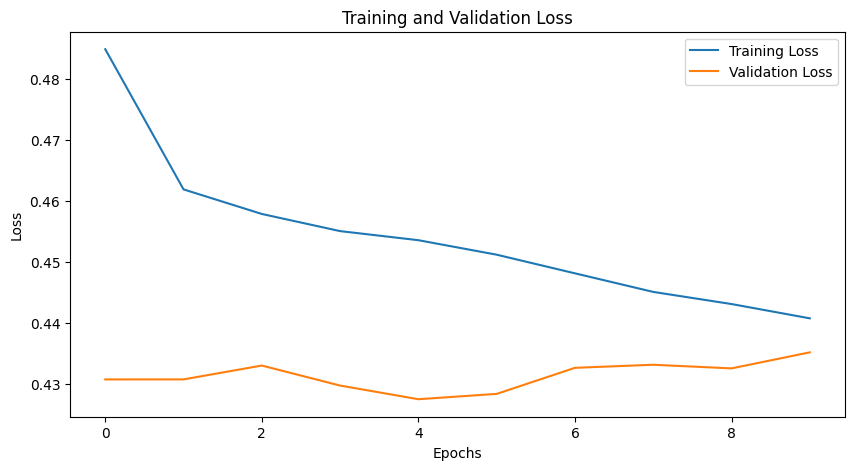

In [80]:
%%time
# Initialize Model
# Update input_dim to include one-hot encoded permno_id length
# input_dim = 128*5+1
input_dim = stock_number+2+stock_number
model = TransformerModel(
    input_dim=input_dim,
    embed_dim=256,
    n_heads=16,
    ff_dim=1024,
    n_layers=1,
    output_dim=len(train_dataset.target_columns),
    # output_dim=1,
    dropout=0.25,
    attn_dropout=0.1,
    residual_dropout=0.1,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training Loop
optimizer = torch.optim.RAdam(model.parameters(), lr=0.00005)
criterion = nn.L1Loss()
# criterion = nn.MSELoss()

train_losses = []
val_losses = []

num_epochs = 200
patience = 5
best_val_loss = float("inf")
patience_counter = 0

print("Starting Training...")
total_batches = num_epochs * len(train_dataloader)
total_start_time = time.time()

for epoch in range(num_epochs):
    start_time = time.time()  # Record the start time
    model.train()
    running_loss = 0.0
    batch_start_time = time.time()
    
    for i, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        output, _ = model(batch["features"].to(device))
        loss = criterion(output, batch["target"].to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 1000 == 0:
            # print(f"Batch {i}, Loss: {loss}, train_loss: {running_loss}")
            elapsed_time = time.time() - batch_start_time
            remaining_batches = len(train_dataloader) - (i + 1)
            estimated_remaining_time_epoch = remaining_batches * (elapsed_time / (i + 1))
            
            total_elapsed_time = time.time() - total_start_time
            total_remaining_batches = total_batches - ((epoch * len(train_dataloader)) + (i + 1))
            estimated_remaining_time_total = total_remaining_batches * (total_elapsed_time / ((epoch * len(train_dataloader)) + (i + 1)))

            print(f"Batch {i}/{len(train_dataloader)}, Loss: {loss:.4f}, "
                  f"Estimated time left for epoch: {time.strftime('%H:%M:%S', time.gmtime(estimated_remaining_time_epoch))}, "
                  f"Estimated time left for training: {time.strftime('%H:%M:%S', time.gmtime(estimated_remaining_time_total))}")
            
    train_losses.append(running_loss / len(train_dataloader))

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_dataloader:
            output, _ = model(batch["features"].to(device))
            loss = criterion(output, batch["target"].to(device))
            val_loss += loss.item()
    val_losses.append(val_loss / len(val_dataloader))

    epoch_time = time.time() - start_time  # Calculate the elapsed time
    print(f"Epoch {epoch+1}/{num_epochs} took {epoch_time:.2f} seconds")
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}")

    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

print("Training Complete")

# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

#### Plot Prediction vs True Values (scaler.inverse_transform)


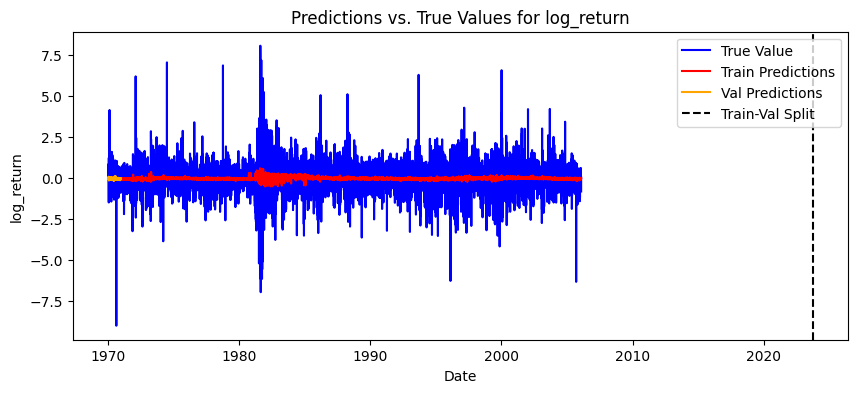

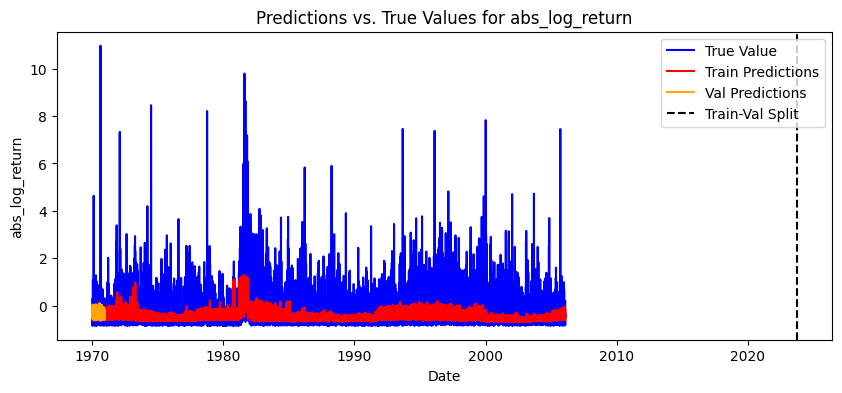

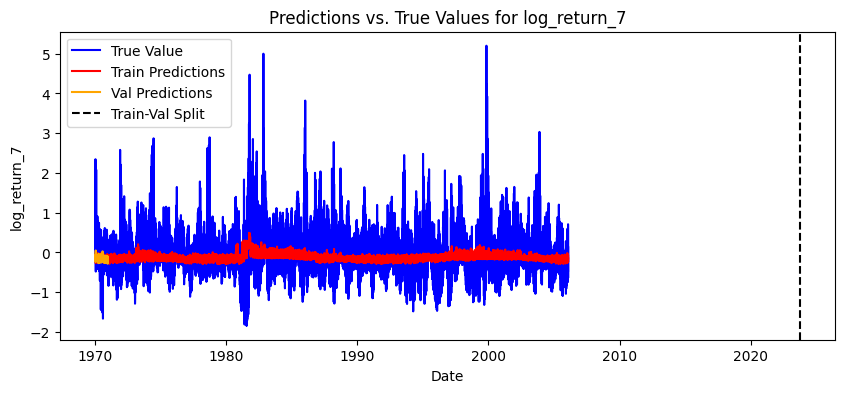

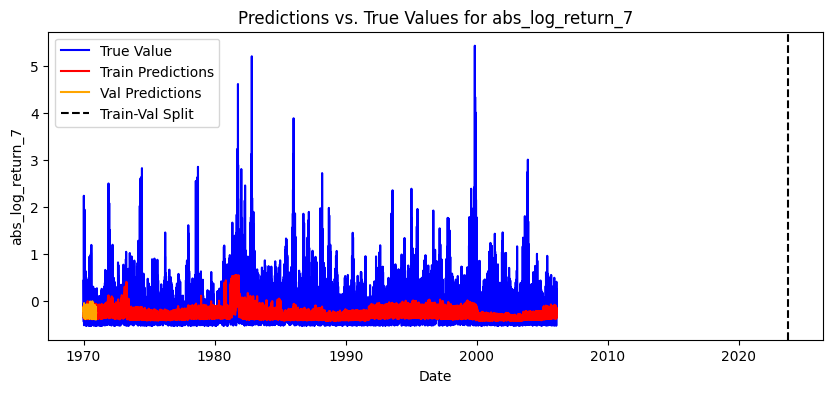

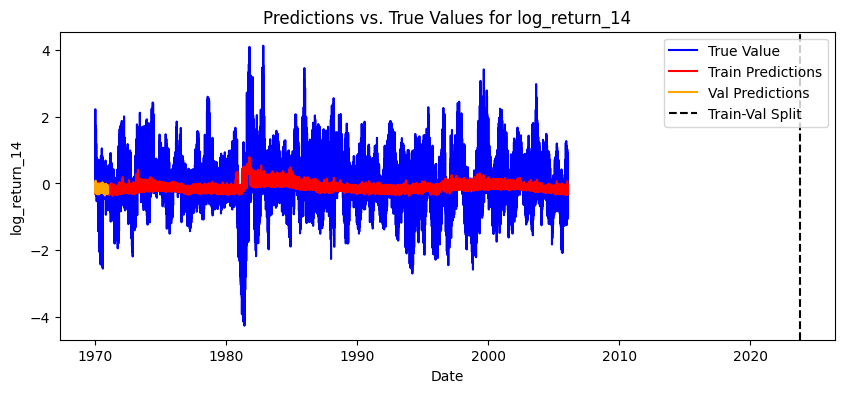

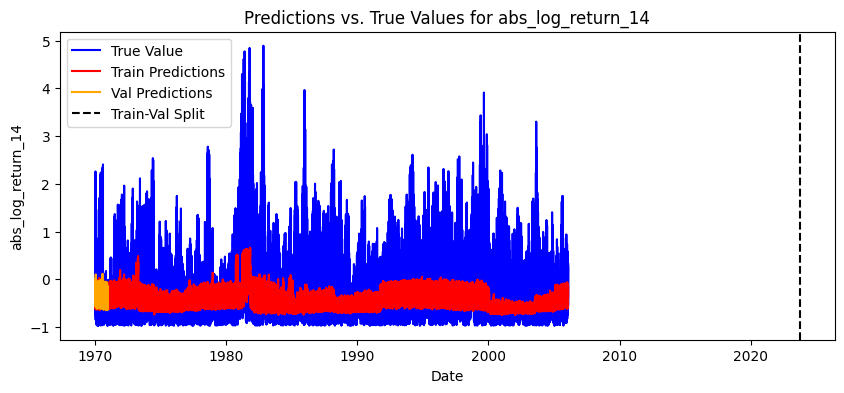

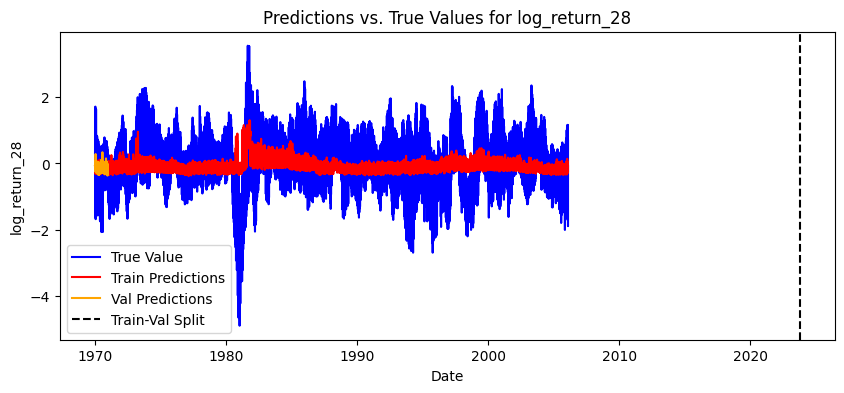

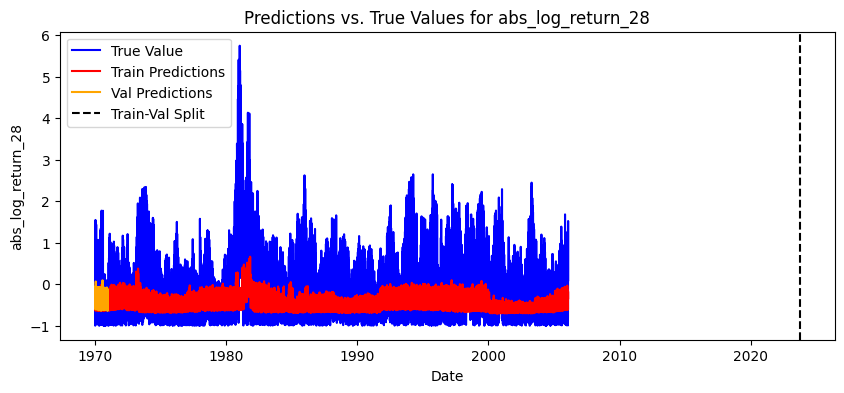

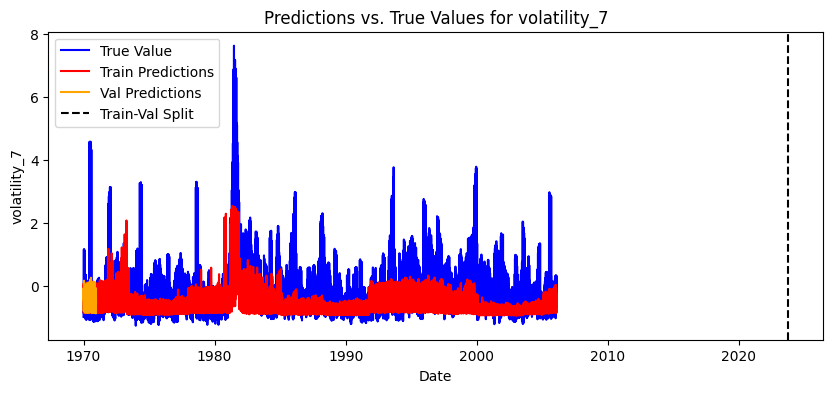

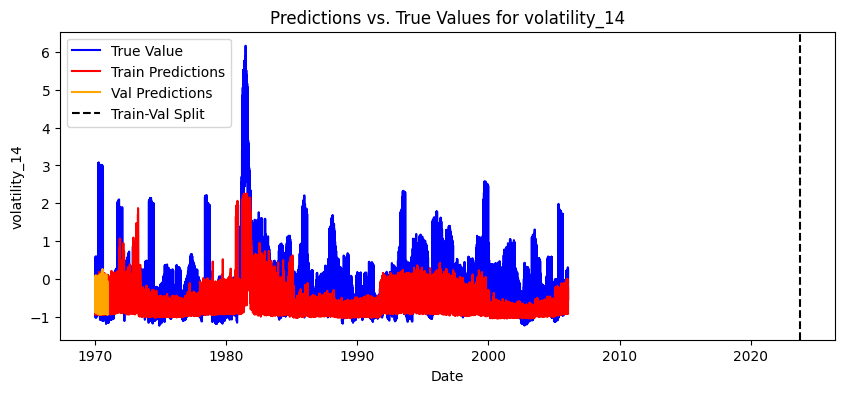

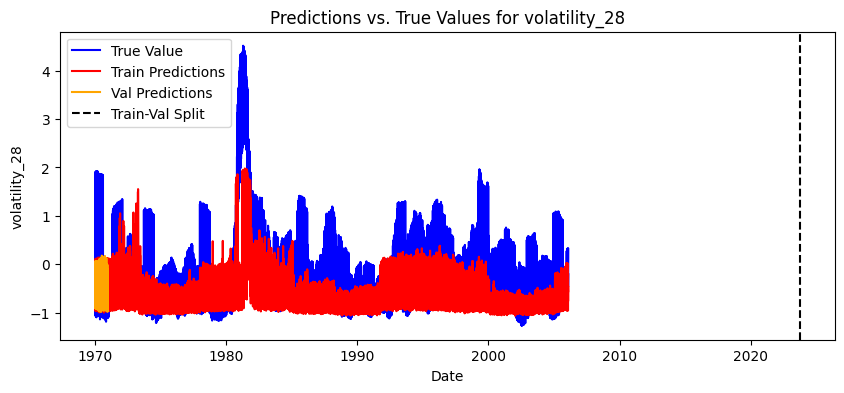

In [84]:
from torch.utils.data import DataLoader

# Assuming the model and dataloaders are already defined and trained
# Also assuming the cleaned_data is available


target_scaler = StandardScaler()
cleaned_data[train_dataset.target_columns] = target_scaler.fit_transform(cleaned_data[train_dataset.target_columns])


# Function to get predictions
def get_predictions(dataloader, model, device):
    model.eval()
    predictions = []
    true_values = []
    with torch.no_grad():
        for batch in dataloader:
            features = batch["features"].to(device)
            target = batch["target"].to(device)
            output, _ = model(features)
            # print(output.shape)
            predictions.append(output.cpu().numpy())
            true_values.append(target.cpu().numpy())
    return np.concatenate(predictions), np.concatenate(true_values)


# Get predictions for training and validation datasets
train_predictions, train_true_values = get_predictions(train_dataloader, model, device)
val_predictions, val_true_values = get_predictions(val_dataloader, model, device)

# Reshape predictions and true values to 2D arrays
train_predictions = train_predictions.reshape(-1, len(train_dataset.target_columns))
train_true_values = train_true_values.reshape(-1, len(train_dataset.target_columns))
val_predictions = val_predictions.reshape(-1, len(val_dataset.target_columns))
val_true_values = val_true_values.reshape(-1, len(val_dataset.target_columns))

# Inverse transform the predictions and true values using target_scaler
train_predictions = target_scaler.inverse_transform(train_predictions)
train_true_values = target_scaler.inverse_transform(train_true_values)
val_predictions = target_scaler.inverse_transform(val_predictions)
val_true_values = target_scaler.inverse_transform(val_true_values)

# Convert predictions and true values to DataFrame
train_predictions_df = pd.DataFrame(train_predictions, columns=train_dataset.target_columns)
train_true_values_df = pd.DataFrame(train_true_values, columns=train_dataset.target_columns)
val_predictions_df = pd.DataFrame(val_predictions, columns=val_dataset.target_columns)
val_true_values_df = pd.DataFrame(val_true_values, columns=val_dataset.target_columns)

# Ensure the date columns have matching lengths
# train_dates = train_data.iloc[window_size : len(train_predictions) + window_size]["date"].values
# if len(train_dates) < len(train_predictions_df):
#     train_dates = np.append(train_dates, [train_dates[-1]] * (len(train_predictions_df) - len(train_dates)))
# train_predictions_df["date"] = train_dates
# train_true_values_df["date"] = train_dates

# val_dates = validation_data.iloc[window_size : len(val_predictions) + window_size]["date"].values
# if len(val_dates) < len(val_predictions_df):
#     val_dates = np.append(val_dates, [val_dates[-1]] * (len(val_predictions_df) - len(val_dates)))
# val_predictions_df["date"] = val_dates
# val_true_values_df["date"] = val_dates


# Plotting function for each label
def plot_predictions_vs_true(label):
    plt.figure(figsize=(10, 4))

    # Plot the train data
    plt.plot(train_true_values_df.index, train_true_values_df[label], label="True Value", color="blue")

    plt.plot(train_predictions_df.index, train_predictions_df[label], label="Train Predictions", color="red")
    plt.plot(val_predictions_df.index, val_predictions_df[label], label="Val Predictions", color="orange")

    plt.axvline(x=pd.to_datetime("2023-09-30"), color="black", linestyle="--", label="Train-Val Split")

    plt.xlabel("Date")
    plt.ylabel(label)
    plt.title(f"Predictions vs. True Values for {label}")
    plt.legend()
    plt.show()


# Plot for all labels
for label in train_dataset.target_columns:
    plot_predictions_vs_true(label)

#### Input Embedding Weights


In [ ]:
input_embedding_weights = model.input_embedding.weight.detach().cpu().numpy().T
print(input_embedding_weights)

In [ ]:
input_embedding_weights[-stock_number:].shape

In [ ]:
cosine_sim_matrix_input_embedding_weights = cosine_similarity(input_embedding_weights)
cosine_sim_matrix_input_embedding_weights

In [ ]:
pd.DataFrame(cosine_sim_matrix_input_embedding_weights).to_csv("cosine_sim_matrix_input_embedding_weights_100_2.csv")

In [ ]:
# Plot the cosine similarity matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cosine_sim_matrix_input_embedding_weights, annot=False, cmap="viridis")
plt.title("Cosine Similarity Matrix of Input Embedding Weights")
plt.xlabel("Embedding Index")
plt.ylabel("Embedding Index")
plt.show()

In [ ]:
# fc_weights = model.fc.weight.detach().cpu().numpy()
# print(fc_weights)

In [ ]:
# fc_weights.shape

In [ ]:
# cosine_sim_matrix_fc_weights = cosine_similarity(fc_weights)
# cosine_sim_matrix_fc_weights

In [ ]:
# plt.figure(figsize=(10, 8))
# sns.heatmap(cosine_sim_matrix_fc_weights, annot=False, cmap='viridis')
# plt.title('Cosine Similarity Matrix of Input Embedding Weights')
# plt.xlabel('Embedding Index')
# plt.ylabel('Embedding Index')
# plt.show()

#### Feed_Forward Weights


In [ ]:
# # To get the weights of the first encoder layer
# encoder_layer_weights = model.transformer.layers[0].state_dict()
# encoder_layer_weights

In [ ]:
# # If you want to get the weights of all encoder layers
# all_encoder_layers_weights = [layer.state_dict() for layer in model.transformer.layers]
# all_encoder_layers_weights

In [ ]:
# # Attention weights
# attention_weights = encoder_layer_weights['self_attn.in_proj_weight']

# # Feedforward weights
# feedforward_weights = encoder_layer_weights['linear1.weight']

# print("Attention Weights:", attention_weights.shape)
# print("Feedforward Weights:", feedforward_weights.shape)

In [ ]:
# feedforward_weights_matrix = feedforward_weights.cpu().numpy()
# feedforward_weights_matrix

In [ ]:
# cosine_sim_matrix_feedforward_weights = cosine_similarity(feedforward_weights_matrix)
# cosine_sim_matrix_feedforward_weights

In [ ]:
# # Plot the cosine similarity matrix as a heatmap
# plt.figure(figsize=(10, 8))
# sns.heatmap(cosine_sim_matrix_feedforward_weights, annot=False, cmap='viridis')
# plt.title('Cosine Similarity Matrix of Input Embedding Weights')
# plt.xlabel('Embedding Index')
# plt.ylabel('Embedding Index')
# plt.show()

#### Extract Last Output Embedding


In [ ]:
# Extract embeddings for each stock
stock_embeddings = {}
model.eval()
with torch.no_grad():
    for batch in train_dataloader:
        _, embeddings = model(batch["features"].to(device))
        for i, permno_id in enumerate(batch["permno_id"]):
            stock_embeddings[permno_id] = embeddings[i].cpu().numpy()  # Keep only the last embedding

In [ ]:
%%time
# Assuming stock_embeddings is a dictionary with permno_id as keys and embeddings as values
embeddings_list = []
permno_ids = []

for permno_id, embedding in stock_embeddings.items():
    permno_ids.append(permno_id)
    embeddings_list.append(embedding)

# Convert the list of embeddings to a numpy array
embeddings_array = np.array(embeddings_list)

# Transform embeddings using cosine similarity
cosine_sim_matrix = cosine_similarity(embeddings_array)
cosine_sim_matrix

In [ ]:
# Plot the cosine similarity matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cosine_sim_matrix, annot=False, cmap="viridis")
plt.title("Cosine Similarity Matrix")
plt.xlabel("Embedding Index")
plt.ylabel("Embedding Index")
plt.show()

In [ ]:
pd.DataFrame(cosine_sim_matrix).to_csv("cosine_sim_matrix_100_2.csv")

In [ ]:
# with torch.no_grad():
#     for batch in train_dataloader:
#         _, embeddings = model(batch["features"].to(device))

In [ ]:
# # output_embedding_matrix = embeddings[:,-1,:].cpu().numpy()
# output_embedding_matrix = embeddings.cpu().numpy()
# output_embedding_matrix

In [ ]:
# output_embedding_matrix.shape

In [ ]:
# cosine_sim_matrix_out_embedding = cosine_similarity(output_embedding_matrix)
# cosine_sim_matrix_out_embedding

In [ ]:
# # Plot the cosine similarity matrix as a heatmap
# plt.figure(figsize=(10, 8))
# sns.heatmap(cosine_sim_matrix_out_embedding, annot=False, cmap='viridis')
# plt.title('Cosine Similarity Matrix of Output Embedding Weights')
# plt.xlabel('Embedding Index')
# plt.ylabel('Embedding Index')
# plt.show()

#### Average Output Embedding


In [ ]:
%%time
# Extract embeddings for each stock
stock_embeddings = {}
model.eval()
with torch.no_grad():
    for batch in train_dataloader:
        _, embeddings = model(batch["features"].to(device))
        for i, permno_id in enumerate(batch["permno_id"]):
            if permno_id not in stock_embeddings:
                stock_embeddings[permno_id] = []
            stock_embeddings[permno_id].append(embeddings[i].cpu().numpy())

In [ ]:
%%time
# Average the embeddings for each stock
for permno_id in stock_embeddings:
    stock_embeddings[permno_id] = np.mean(stock_embeddings[permno_id], axis=0)

In [ ]:
%%time
# Assuming stock_embeddings is a dictionary with permno_id as keys and embeddings as values
embeddings_list = []
permno_ids = []

for permno_id, embedding in stock_embeddings.items():
    permno_ids.append(permno_id)
    embeddings_list.append(embedding)

# Convert the list of embeddings to a numpy array
embeddings_array = np.array(embeddings_list)

# Transform embeddings using cosine similarity
cosine_sim_matrix = cosine_similarity(embeddings_array)
cosine_sim_matrix

In [ ]:
# Plot the cosine similarity matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cosine_sim_matrix, annot=False, cmap="viridis")
plt.title("Cosine Similarity Matrix")
plt.xlabel("Embedding Index")
plt.ylabel("Embedding Index")
plt.show()

In [ ]:
# # Initialize an empty tensor to accumulate the embeddings
# accumulated_embeddings = torch.zeros(128, 256).to(device)
# total_batches = 0

# with torch.no_grad():
#     for batch in train_dataloader:
#         _, embeddings = model(batch["features"].to(device))
#         #print(embeddings)
#         accumulated_embeddings += embeddings.sum(dim=1)
#         # total_batches += batch["features"].size(0)
#         total_batches += embeddings.size(1)

# # Divide the accumulated embeddings by the total number of batches to get the average
# average_embeddings = accumulated_embeddings / total_batches
# print(total_batches)
# average_embeddings

In [ ]:
# average_embeddings.shape

In [ ]:
# batch["features"].shape

In [ ]:
# batch["features"].size(0)

In [ ]:
# # Plot the cosine similarity matrix as a heatmap
# plt.figure(figsize=(10, 8))
# sns.heatmap(cosine_similarity(average_embeddings.cpu().numpy()), annot=False, cmap='viridis')
# plt.title('Cosine Similarity Matrix of Input Embedding Weights')
# plt.xlabel('Embedding Index')
# plt.ylabel('Embedding Index')
# plt.show()